# SkimLit Project

An NLP project to make reading medical abstracts easier

Going to be replicating the deep learning model behind the 2017 paper https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.**ipynb**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-493dc705-d79f-87ff-6a39-6f7199eea4eb)


### Get Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


* train.txt - training samples.
* dev.txt - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* test.txt - test samples.

In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocess Data

In [6]:
def get_lines(filename):
  """"""
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_linenumbers(filename):
  """"Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = ''
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [10]:
train_data = preprocess_text_with_linenumbers(data_dir+"train.txt")

In [11]:
train_data[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
val_data = preprocess_text_with_linenumbers(data_dir+"dev.txt")
test_data = preprocess_text_with_linenumbers(data_dir+"test.txt")

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

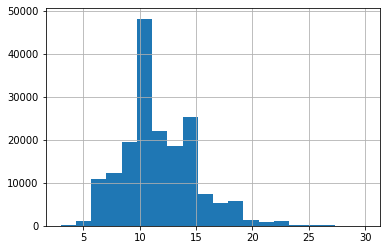

In [15]:
train_df.total_lines.hist(bins = 20)

Get lists of sentences

In [16]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

#### Create Numerical Labels

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
ohe = OneHotEncoder(sparse = False)

In [19]:
train_labels_one_hot = ohe.fit_transform(train_df.target.to_numpy().reshape(-1,1))

In [20]:
val_labels_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))

#### Label Encode Labels

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a Series of Models

Going to work towards building a model that replicates that seen in the link below

[Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)

### Baseline

[Sklearn choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

First model will be a tf-dif vectorizer that uses a Naive Bayes classifier

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
baseline = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
baseline.fit(X=train_sentences, 
            y=train_labels_encoded);

In [24]:
baseline_preds = baseline.predict(val_sentences)

In [25]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-06 15:50:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-06 15:50:01 (83.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
from helper_functions import *

In [28]:
# Calculate baseline results
baseline_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = baseline_preds
)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#### Preparing Text for Deep Sequencing Models

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

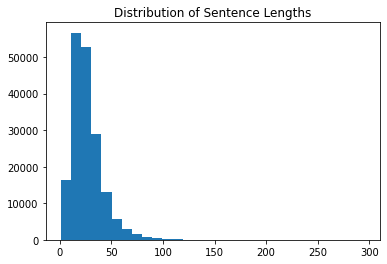

In [31]:
plt.hist(sent_lens, bins = 30)
plt.title('Distribution of Sentence Lengths')
plt.show()

What sentence length covers 95% of samples?

In [32]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
np.max(sent_lens)

296

#### Create a Text Vectorization Layer

In [34]:
# How many words are in our vocabulary?
max_tokens = 68000

In [35]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out on random sentences
import random

In [38]:
target_sen = random.choice(train_sentences)
print(f"Text:\n{target_sen}")
print(f"\nLength of text: {len(target_sen.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sen])}")

Text:
the aim of this study was to evaluate the combination of endoscopic ultrasonography ( eus ) and computed tomography ( ct ) in predicting the maneuvers for therapeutic endoscopy for gastrointestinal submucosal tumors ( smts ) .

Length of text: 37

Vectorized text:
[[    2   267     4    23    17    10     6   164     2   269     4  1304
   3210 13330     3  1490  1236   663     5  2947     2  9138    11   438
   2634    11  1027  8356  1563 28465     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [40]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [41]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [42]:
print(f"Sentence before vectorization:\n{target_sen}\n")
vectorized_sen = text_vectorizer([target_sen])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sen}\n")
embedded_sen = token_embed(vectorized_sen)
print(f"Sentence after embedding:\n{embedded_sen}\n")
print(f"Embedded sentence shape: {embedded_sen.shape}")

Sentence before vectorization:
the aim of this study was to evaluate the combination of endoscopic ultrasonography ( eus ) and computed tomography ( ct ) in predicting the maneuvers for therapeutic endoscopy for gastrointestinal submucosal tumors ( smts ) .

Sentence after vectorization (before embedding):
[[    2   267     4    23    17    10     6   164     2   269     4  1304
   3210 13330     3  1490  1236   663     5  2947     2  9138    11   438
   2634    11  1027  8356  1563 28465     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01347348 -0.04309842 -0.01582428 ...  0.00354171 -0.03050747
   -0.02682365]
  [-0.02367225 -0.03331745  0.00052404 ... -0.02771731 -0.00063594
    0.02351018]
  [-0.0243968   0.02383173  0.01889578 ...  0.03937842 -0.04542307
   -0.02924052]
  ...
  [ 0.0091772   0.01116177  0.02103753 ...  0.01799894 -0.01469745
 

#### Creating Datasets

Setting up data to run as fast as possible with the tf.data API 

* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) 
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [43]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Conv-1D With Token Embeddings

In [45]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_cnn = tf.keras.Model(inputs, outputs)

# Compile
model_cnn.compile(loss="categorical_crossentropy", # if labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [47]:
model_cnn_history = model_cnn.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9265 - accuracy: 0.6305 - val_loss: 0.6932 - val_accuracy: 0.7347
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6574 - accuracy: 0.7592 - val_loss: 0.6342 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6143 - accuracy: 0.7786 - val_loss: 0.5929 - val_accuracy: 0.7826


In [48]:
model_cnn_preds = model_cnn.predict(valid_dataset)
model_cnn_preds.shape

(30212, 5)

In [49]:
model_cnn_preds = np.argmax(model_cnn_preds, axis = 1)

In [50]:
model_cnn_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_cnn_preds
)
model_cnn_results

{'accuracy': 78.73692572487752,
 'f1': 0.7848003241458356,
 'precision': 0.7839588154745208,
 'recall': 0.7873692572487753}

### Feature Extraction W/ Pretrained Embeddings

Will utilise univesal sentence encoder

[Pretrain Embeddings from Tensorflow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) 

In [51]:
import tensorflow_hub as hub

In [52]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
a decision-analytic markov model , based on mantra-paf ( medical antiarrhythmic treatment or radiofrequency ablation in paroxysmal atrial fibrillation ) study data , was developed to study long-term effects and costs of rfa compared with aads as first-line treatment .

Sentence after embedding:
[-0.06578299  0.00067596  0.04594054 -0.06406882 -0.06866743 -0.07065365
  0.02740936 -0.07069691  0.06576213 -0.04392166  0.0815353  -0.0382848
  0.05542598 -0.00339527 -0.00907334  0.00457724 -0.0825304  -0.04593541
 -0.00703447 -0.07328405  0.02421401  0.03093891 -0.00118396 -0.010686
 -0.01718909 -0.00230237  0.02750754  0.01748022  0.01069497  0.01162194] (truncated output)...

Length of sentence embedding:
512


In [54]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_use = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_use.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
model_use.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [56]:
model_use.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9138 - accuracy: 0.6512 - val_loss: 0.7939 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7683 - accuracy: 0.7017 - val_loss: 0.7524 - val_accuracy: 0.7015
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7520 - accuracy: 0.7124 - val_loss: 0.7372 - val_accuracy: 0.7121


In [57]:
model_use_preds = model_use.predict(val_sentences)

In [58]:
model_use_preds = np.argmax(model_use_preds, axis = 1)

In [59]:
model_use_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_use_preds
)
model_use_results

{'accuracy': 71.33920296570899,
 'f1': 0.7104778066302133,
 'precision': 0.713336317166679,
 'recall': 0.7133920296570899}

### Conv-1D W/ Character Embeddings

In [60]:
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a   d e c i s i o n - a n a l y t i c   m a r k o v   m o d e l   ,   b a s e d   o n   m a n t r a - p a f   (   m e d i c a l   a n t i a r r h y t h m i c   t r e a t m e n t   o r   r a d i o f r e q u e n c y   a b l a t i o n   i n   p a r o x y s m a l   a t r i a l   f i b r i l l a t i o n   )   s t u d y   d a t a   ,   w a s   d e v e l o p e d   t o   s t u d y   l o n g - t e r m   e f f e c t s   a n d   c o s t s   o f   r f a   c o m p a r e d   w i t h   a a d s   a s   f i r s t - l i n e   t r e a t m e n t   .'

In [61]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [62]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.0600e+03, 1.0281e+04, 2.1922e+04, 2.8139e+04, 3.0289e+04,
        2.6219e+04, 1.9853e+04, 1.4492e+04, 9.6420e+03, 6.1370e+03,
        4.0170e+03, 2.5600e+03, 1.5340e+03, 9.3500e+02, 6.4300e+02,
        4.4600e+02, 2.5600e+02, 1.8800e+02, 1.1900e+02, 8.0000e+01,
        5.8000e+01, 4.7000e+01, 2.6000e+01, 2.4000e+01, 1.2000e+01,
        1.2000e+01, 1.0000e+01, 9.0000e+00, 7.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 2.8700e+01, 5.6400e+01, 8.4100e+01, 1.1180e+02,
        1.3950e+02, 1.6720e+02, 1.9490e+02, 2.2260e+02, 2.5030e+02,
        2.7800e+02, 3.0570e+02, 3.3340e+02, 3.6110e+02, 3.8880e+02,
        4.1650e+02, 4.4420e+02, 4.7190e+02, 4.9960e+02, 5.2730e+02,
        5.5500e+02, 5.8270e+02, 6.1040e+02, 6.

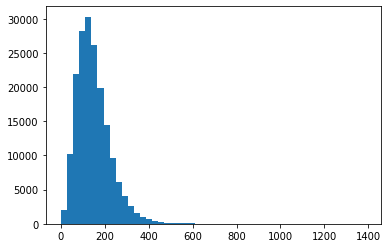

In [63]:
plt.hist(char_lens, bins = 50)

In [64]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [67]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p h y s i c a l   a c t i v i t y   (   p a   )   a n d   n u t r i t i o n   a r e   t h e   c o r n e r s t o n e s   o f   d i a b e t e s   m a n a g e m e n t   .

Length of chars: 71

Vectorized chars:
[[14 13 19  9  4 11  5 12  5 11  3  4 21  4  3 19 14  5  5  6 10  6 16  3
   8  4  3  4  7  6  5  8  2  3 13  2 11  7  8  6  2  8  9  3  7  6  2  9
   7 17 10  4  5 22  2  3  2  9 15  5  6  5 18  2 15  2  6  3  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  

Padded with zeros up to 95% sample length

### Set up Character Level Embedding

In [69]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = 'char_emded')

In [70]:
char_bed_example = char_embed(char_vectorizer([random_train_chars]))

In [71]:
char_bed_example

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.0220253 ,  0.04126246,  0.03777829, ...,  0.02534394,
         -0.01279833,  0.0244094 ],
        [ 0.00629994, -0.02528244, -0.00301349, ...,  0.04442253,
          0.0380331 ,  0.02709252],
        [ 0.01691299, -0.03619904,  0.01221764, ...,  0.00141195,
         -0.02702552,  0.02456692],
        ...,
        [-0.01907183, -0.04834309, -0.00649209, ...,  0.03812853,
          0.04806396, -0.00678528],
        [-0.01907183, -0.04834309, -0.00649209, ...,  0.03812853,
          0.04806396, -0.00678528],
        [-0.01907183, -0.04834309, -0.00649209, ...,  0.03812853,
          0.04806396, -0.00678528]]], dtype=float32)>

### Conv-1D for Character Level Only

In [72]:
inputs = layers.Input(shape = (1,), dtype = 'string')
text_vec = char_vectorizer(inputs)
text_embed = char_embed(text_vec)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(text_embed)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes)(x)

model_char_conv = tf.keras.Model(inputs, outputs)

In [73]:
model_char_conv.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_emded (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [74]:
model_char_conv.compile(loss = 'categorical_crossentropy',
                        optimizer = 'adam',
                        metrics = ['accuracy'])

In [75]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [76]:
model_char_conv.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 9.1813 - accuracy: 0.2320 - val_loss: 9.0664 - val_accuracy: 0.2364
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 8.8827 - accuracy: 0.2393 - val_loss: 9.0879 - val_accuracy: 0.2031
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 9.0897 - accuracy: 0.1970 - val_loss: 9.0825 - val_accuracy: 0.1905


In [77]:
model_char_conv_preds = np.argmax(model_char_conv.predict(val_char_dataset), axis = 1)

In [78]:
model_char_conv_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_char_conv_preds
)
model_char_conv_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 19.601482854494904,
 'f1': 0.13663424217107617,
 'precision': 0.11974786651291705,
 'recall': 0.19601482854494903}

### Combining Token & Character Embeddings

Create a hybrid layer

In [79]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_comb = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [80]:
model_comb.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [81]:
from tensorflow.keras.utils import plot_model

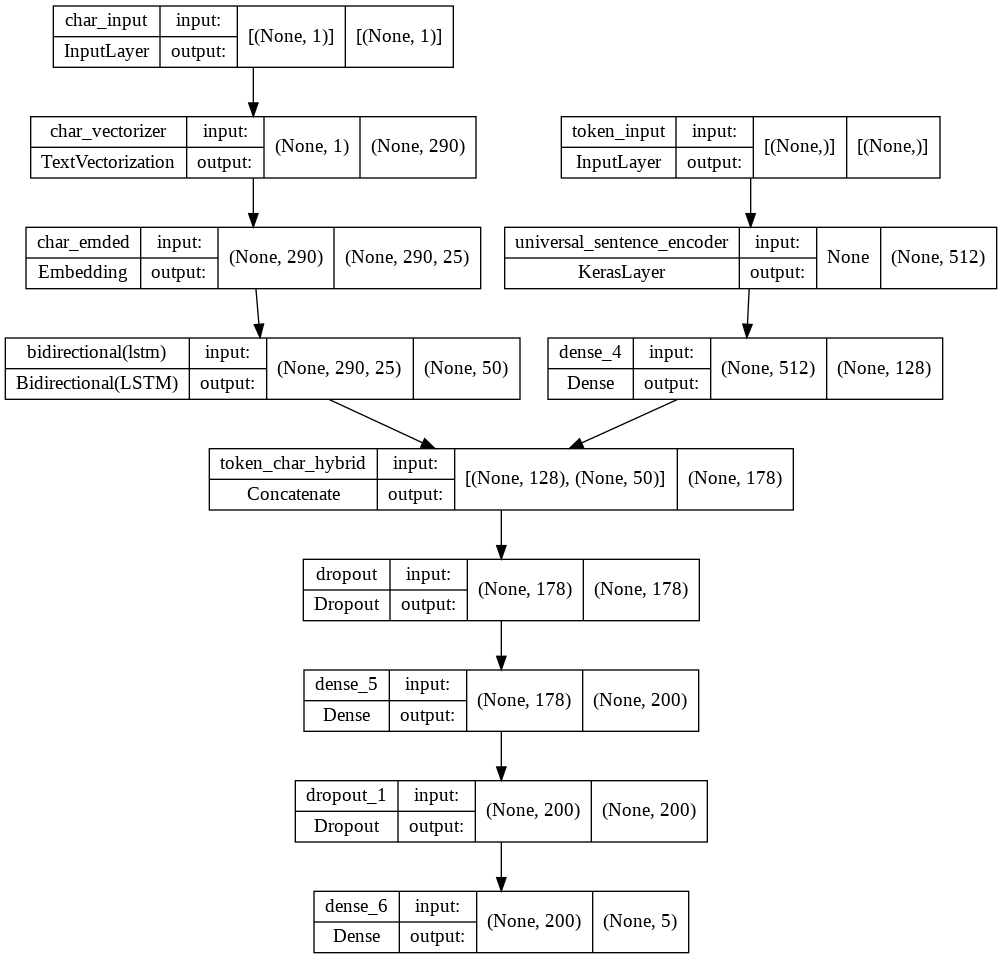

In [82]:
plot_model(model_comb, show_shapes = True)

In [83]:
model_comb.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [84]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
model_comb.fit(
    train_char_token_dataset,
    steps_per_epoch = 0.15*len(train_char_token_dataset),
    validation_data = val_char_token_dataset,
    validation_steps = 0.15*len(val_char_token_dataset),
    epochs = 5
)

Epoch 1/5
844/844 [==============================] - 50s 49ms/step - loss: 0.9133 - accuracy: 0.6388 - val_loss: 0.7319 - val_accuracy: 0.7190
Epoch 2/5
844/844 [==============================] - 36s 43ms/step - loss: 0.7719 - accuracy: 0.7020 - val_loss: 0.6847 - val_accuracy: 0.7392
Epoch 3/5
844/844 [==============================] - 40s 47ms/step - loss: 0.7352 - accuracy: 0.7220 - val_loss: 0.6574 - val_accuracy: 0.7513
Epoch 4/5
844/844 [==============================] - 36s 43ms/step - loss: 0.7406 - accuracy: 0.7164 - val_loss: 0.6433 - val_accuracy: 0.7529
Epoch 5/5
844/844 [==============================] - 42s 50ms/step - loss: 0.7067 - accuracy: 0.7312 - val_loss: 0.6424 - val_accuracy: 0.7537


In [86]:
model_comb.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6487 - accuracy: 0.7516


[0.6486597657203674, 0.751588761806488]

In [87]:
model_comb_preds = model_comb.predict(val_char_token_dataset)

In [88]:
model_comb_preds

array([[6.06563330e-01, 1.94266468e-01, 2.00456544e-03, 1.88478246e-01,
        8.68738722e-03],
       [4.29042369e-01, 4.49836284e-01, 3.04119685e-03, 1.16317764e-01,
        1.76240236e-03],
       [5.09383738e-01, 5.17725162e-02, 4.31880802e-02, 3.72098058e-01,
        2.35575810e-02],
       ...,
       [4.11294692e-04, 1.14683982e-03, 5.34334444e-02, 1.16981777e-04,
        9.44891393e-01],
       [2.85927188e-02, 1.51858702e-01, 1.79363415e-01, 9.54637025e-03,
        6.30638778e-01],
       [2.65854925e-01, 5.24547279e-01, 1.74282208e-01, 1.99173354e-02,
        1.53982062e-02]], dtype=float32)

In [89]:
model_comb_preds = np.argmax(model_comb_preds, axis = 1)

In [90]:
model_comb_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_comb_preds
)
model_comb_results

{'accuracy': 75.158877267311,
 'f1': 0.7464347140827945,
 'precision': 0.7543956887588904,
 'recall': 0.75158877267311}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [91]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [92]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

Create positional embeddings 

In [93]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [94]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

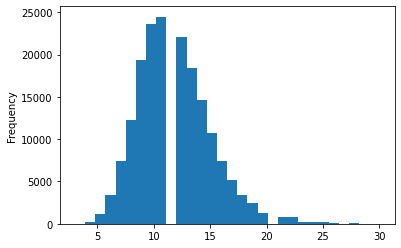

In [95]:
train_df.total_lines.plot(kind = 'hist', bins = 30)

In [96]:
np.percentile(train_df.total_lines, 98)

20.0

In [97]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#### Building a tribrid embedding mode

In [99]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [100]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

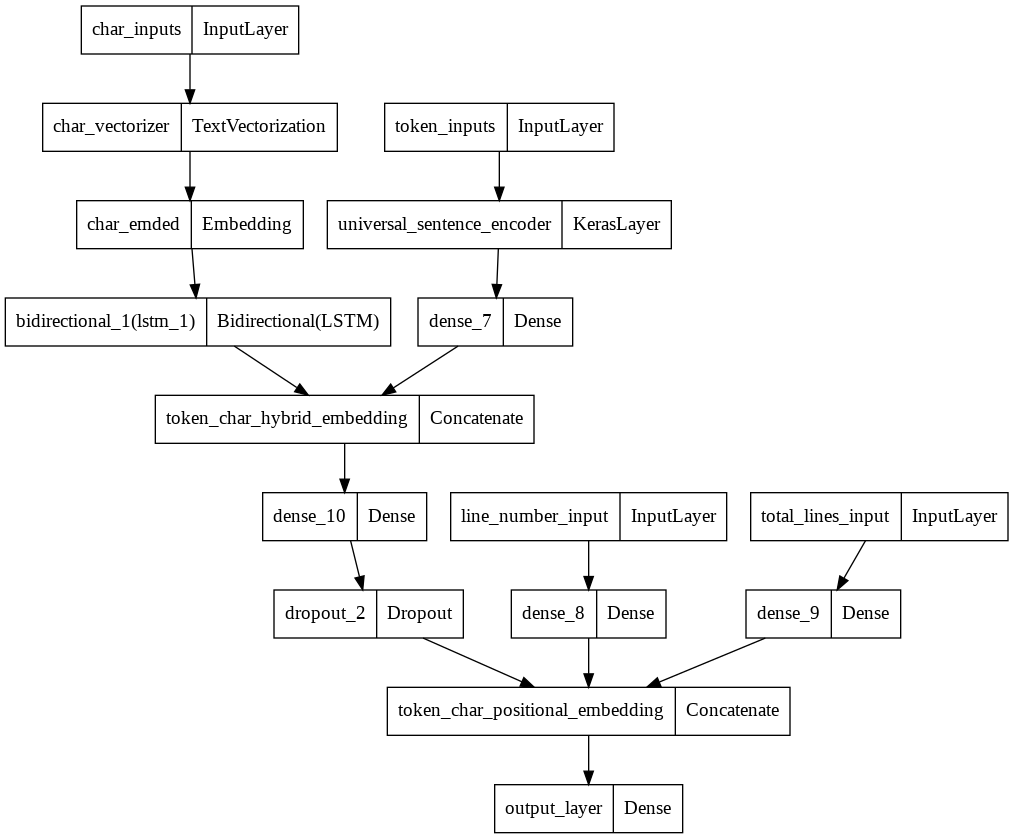

In [101]:
plot_model(model_5)

In [102]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [103]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [104]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 51ms/step - loss: 1.0965 - accuracy: 0.7248 - val_loss: 0.9843 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9674 - accuracy: 0.8157 - val_loss: 0.9505 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.9498 - accuracy: 0.8228 - val_loss: 0.9382 - val_accuracy: 0.8318


In [106]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 25s 21ms/step


array([[0.5017925 , 0.10290042, 0.01258285, 0.3627224 , 0.0200018 ],
       [0.5279603 , 0.08567357, 0.0591369 , 0.3135332 , 0.01369606],
       [0.30820933, 0.11565585, 0.14268811, 0.3652465 , 0.06820019],
       ...,
       [0.03336548, 0.10124853, 0.0436408 , 0.027987  , 0.7937582 ],
       [0.03383611, 0.25470647, 0.08924601, 0.02372363, 0.5984878 ],
       [0.22268778, 0.54514444, 0.1177117 , 0.04655495, 0.06790111]],
      dtype=float32)

In [107]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [108]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.38077585065537,
 'f1': 0.8324890673234404,
 'precision': 0.8329095036998404,
 'recall': 0.8338077585065536}